<a href="https://colab.research.google.com/github/intellitrend-global/google_hackathon_bq_ai/blob/main/process_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [1]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [2]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo
# we can use an array / list if we need to process more than one company

company1 = "bankofmontreal"
company2 ="wellsfargo"
company3 = "jpmorganchase"

DATA_FILES_PATH="gs://report_insights"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ

OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro" # or any other gemini model
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [3]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [5]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [6]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [7]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [8]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [4]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/jpmorganchase/*', '{DATA_FILES_PATH}/bankofmontreal/*', '{DATA_FILES_PATH}/wellsfargo/*']
);
"""

# Uncomment to process a single file for testing

# create_external_table_sql = f"""
# CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
# WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
# OPTIONS (
#   object_metadata = 'SIMPLE',
#   uris = ['{DATA_FILES_PATH}/bankofmontreal/bankofmontreal_annualreport_2020.pdf']
# );
# """

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 32 files in storage
Sample files:


                                                 uri      size
0  gs://report_insights/jpmorganchase/jpmorgancha...   6777434
1  gs://report_insights/jpmorganchase/jpmorgancha...   8302860
2  gs://report_insights/jpmorganchase/jpmorgancha...   8488946
3  gs://report_insights/jpmorganchase/jpmorgancha...  16797166
4  gs://report_insights/jpmorganchase/jpmorgancha...   6814192

[5 rows x 2 columns]


#  ֎ Extract Financial & ESG Data - **Using ML.GENERATE_TEXT**

In [5]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability details and metrics from text, tabular and image data for each PDF.

      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...
⏳ Processing... 
✅ Successfully processed 32 files!


# 🧹 Extract **Clean** Text Response

In [6]:
print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2019.pdf
Text: Here are the ESG and financial details from the 2019 JPMorgan Chase & Co. Environmental, Social & Governance Report.

### Financial Data

| Metric | Value | Year | Notes |
| --- | --- | --- | --- |
| ...

File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2024.pdf
Text: Here are the financial and sustainability details from the JPMorgan Chase 2024 Climate Report.

### **General Information**

| Metric | Value |
| --- | --- |
| **Company Name** | JPMorgan Chase & Co. ...

File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2020.pdf
Text: Based on the JPMorgan Chase & Co. 2020 Environmental, Social & Governance Report, here are the requested financial and sustainability details and metrics.

### Financial Details

*   **Total Assets:**...



In [28]:
from IPython.display import display, Markdown

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

user_question="'What is the total revenue this year?'"
user_question="'Generate tabular data for financial metrics'"
selected_company = "bankofmontreal"
selected_year = "2024"
selected_report_type="annual"


default_questions="""
CONCAT('Answer all the below questions:',
'Read the data and fetch the below details:',
'Financial Performance',
'What is the total revenue this year?',
'How has revenue changed compared to last year?',
'What is the net profit or loss?',
'How have the earnings per share (EPS) changed?',
'Are gross margins improving or declining?',
'Are operating margins stable or volatile?',
'How has net margin shifted year over year?',
'Is cash flow from operations positive and consistent?',
'How much free cash flow is available?',
'How are working capital levels trending?',

'Balance Sheet & Liquidity',
'What is the total debt level?',
'Is the debt-to-equity ratio rising or falling?',
'Does the company have enough liquidity to cover short-term liabilities?',
'What is the current ratio and quick ratio?',
'How much cash and equivalents are available?',
'Are interest expenses sustainable?',
'How sensitive is the company to interest rate changes?',
'What is the level of contingent liabilities?',

'Business Strategy',
'What are the company’s core growth initiatives?',
'Is management investing in new markets or products?',
'How much is spent on research and development (R&D)?',
'Are acquisitions or divestitures planned?',
'Is the company expanding geographically?',
'What is the company competitive advantage?',
'Is the advantage sustainable against competitors?',
'Is digital transformation a core part of the strategy?',

'Risk Factors',
'What macroeconomic risks affect the business?',
'What industry-specific risks are highlighted?',
'What operational risks are disclosed?',
'Are supply chain risks material?',
'Are legal or regulatory risks mentioned?',
'How is foreign exchange risk managed?',
'How dependent is revenue on a few customers?',
'Are raw material price risks significant?',

'Governance & Leadership',
'Is the board majority independent?',
'How many women or minorities are on the board?',
'Is executive compensation performance-linked?',
'Does management own significant equity?',
'Are shareholder rights well protected?',
'Is succession planning disclosed?',
'Has management delivered on past promises?',
'Is the auditor independent and credible?',

'Shareholder Value',
'Is the company paying dividends?',
'Is the dividend payout sustainable?',
'Is the dividend policy clear?',
'Are share buybacks taking place?',
'Is return on equity (ROE) improving?',
'Is return on assets (ROA) stable?',
'Has shareholder equity grown consistently?',
'What is the earnings guidance for next year?',

'Investor Questions – Sustainability Reports',

'Environmental',
'What is the total Scope 1 emissions?',
'What is the total Scope 2 emissions?',
'What is the total Scope 3 emissions?',
'Are science-based targets disclosed?',
'Has the company committed to net-zero?',
'What percentage of energy is renewable?',
'Is energy efficiency improving year over year?',
'What is the total water withdrawal?',
'What is water recycled or reused?',
'Is the company exposed to water stress?',
'How much total waste is generated?',
'How much waste is recycled or diverted from landfill?',
'Are hazardous waste levels disclosed?',
'How sustainable are raw material sourcing practices?',
'Are biodiversity risks addressed?',

'Social',
'What is the total workforce size?',
'What percentage of employees are women?',
'What percentage of leadership roles are held by women?',
'What is minority representation in the workforce?',
'What is the employee turnover rate?',
'How many workplace injuries occurred?',
'What is the lost-time injury frequency rate?',
'Are labor rights respected across the supply chain?',
'Is child labor risk disclosed in supply chains?',
'Are employee training hours increasing per year?',
'Are wages above local living wage levels?',
'Is there employee engagement survey data?',
'What community development initiatives exist?',
'What philanthropic contributions were made?',
'Is there disclosure on data privacy and cybersecurity?',

'Governance (ESG-specific)',
'Is there a dedicated board ESG committee?',
'How often does the board review ESG matters?',
'Is ESG risk included in enterprise risk management?',
'Is executive compensation tied to ESG goals?',
'Are ESG targets linked to management incentives?',
'Is ESG performance externally assured?',
'Are ESG disclosures aligned with GRI or SASB?',
'Does the company report under TCFD or ISSB?',
'Is CDP reporting publicly available?',
'Are stakeholder engagement practices disclosed?',

'Risk & Opportunity',
'What are the identified physical climate risks?',
'What are the identified transition risks?',
'Is there disclosure on carbon pricing exposure?',
'How dependent is revenue on carbon-intensive activities?',
'What sustainability-linked opportunities are identified?',
'Are green products or services generating revenue?',
'Is access to sustainable finance increasing?',
'Are suppliers evaluated for ESG performance?',
'Are ESG clauses included in supplier contracts?',
'Is there disclosure on product lifecycle impacts?'
)
"""

# -------------------------------
# Build prompt
# -------------------------------
if user_question.strip():
    question_block = f"{user_question}"
else:
    question_block = f"{default_questions}"



generate_text_sql2 = f"""
 SELECT
    response_text,
    AI.GENERATE(
    (
      CONCAT({question_block}),
    response_text),
    connection_id => '{PROJECT_LOCATION}.{CLOUD_RES_CONN}',
  endpoint => '{MODEL_ENDPOINT}'
).result
FROM `{QUALIFIED_CURATED_TABLE_ID}`
WHERE (uri like '%{selected_company}%')
AND uri like '%{selected_year}%'
AND uri like '%{selected_report_type}%';
"""



#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    # job = client.query(generate_text_sql2)
    # job.result()

    sample_df2 = bpd.read_gbq(generate_text_sql2)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df2.iterrows():
      text=row['result']
      display(Markdown(text))

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...
⏳ Processing... 

📝 Sample extracted text:


Of course. Here is the provided information organized into a series of tables, separating the primary financial data from the quantitative and qualitative ESG metrics for clarity.

### Financial Highlights (FY 2024)

This table includes the core financial performance and position metrics from the report.

| Metric | Value | Unit |
| :--- | :--- | :--- |
| **Size & Scale** | | |
| Total Assets | 1,409,647 | million CAD |
| Total Deposits | 982,440 | million CAD |
| Total Loans and Acceptances (Gross) | 682,731 | million CAD |
| Total Equity | 84,286 | million CAD |
| Assets under Management (AUM) | 422,701 | million CAD |
| Assets under Administration (AUA) | 361,250 | million CAD |
| **Profitability & Earnings** | | |
| Total Revenue (Reported) | 32,795 | million CAD |
| Net Income (Reported) | 7,327 | million CAD |
| Net Income (Adjusted) | 7,449 | million CAD |
| Diluted Earnings Per Share (EPS) (Reported) | 9.51 | CAD |
| Diluted Earnings Per Share (EPS) (Adjusted) | 9.68 | CAD |
| Return on Equity (ROE) (Reported) | 9.7 | % |
| Return on Equity (ROE) (Adjusted) | 9.8 | % |
| Return on Tangible Common Equity (ROTCE) (Reported) | 13.5 | % |
| Return on Tangible Common Equity (ROTCE) (Adjusted) | 13.1 | % |
| **Shareholder Metrics** | | |
| Book Value per Share | 104.40 | CAD |
| Dividends Declared per Share | 6.12 | CAD |
| **Risk & Capital Adequacy** | | |
| Total Provision for Credit Losses (PCL) | 3,761 | million CAD |
| Total PCL-to-average net loans and acceptances | 0.57 | % |
| Total Risk-Weighted Assets (RWA) | 420,838 | million CAD |
| Common Equity Tier 1 (CET1) Ratio | 13.6 | % |
| Tier 1 Capital Ratio | 15.4 | % |
| Total Capital Ratio | 17.6 | % |
| Leverage Ratio | 4.4 | % |
| Total Loss Absorbing Capacity (TLAC) Ratio | 29.3 | % |
| **Liquidity** | | |
| Liquidity Coverage Ratio (LCR) | 132 | % |
| Net Stable Funding Ratio (NSFR) | 117 | % |

---

### ESG Quantitative Metrics

This table extracts the quantifiable data points from the ESG highlights section.

| Category | Metric | Value | Unit | Period / Year | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Social** | BMO EMpower 2.0 Commitment | >40 | billion USD | 5-Year Goal | A five-year commitment to support underserved communities in the U.S. |
| **Social** | BMO EMpower 2.0 Progress | 12.9 | billion USD | First 18 months | Amount delivered in the first 18 months of the program. |
| **Social**| Employee Giving Campaign | 31 | million CAD | 2024 | Total raised for charities across Canada and the U.S. |
| **Social** | Employee Giving to United Way | >13 | million CAD | 2024 | Portion of the employee giving campaign directed to United Way. |
| **Social**| Employee Giving Participation Rate | 88 | % | 2024 | Percentage of employees participating in the annual giving campaign. |
| **Social** | Equity Through Education (Cumulative Raised) | >33 | million CAD | To Date | Total funds raised over the program's 20-year history. |
| **Social**| Equity Through Education (Students Supported) | ~5,500 | Students | To Date | Cumulative number of students empowered by the program. |
| **Social** | Number of Employees | 53,597 | People | FY2024 | Total employees at fiscal year-end. |
| **Social** | Employee Share Ownership (Canada) | 78.4 | % | 2024 | Participation rate for Canadian employees in the ESOP. |
| **Governance**| Supplier Spend (Canada & U.S.) | >8.05 | billion CAD | 2024 | Total procurement of goods and services from suppliers. |

---

### ESG Initiatives & Recognitions

This table summarizes key qualitative highlights, including program launches, strategies, and major awards.

| Category | Initiative / Recognition | Details |
| :--- | :--- | :--- |
| **Environment** | Climate Ambition | To be clients' lead partner in the transition to a net-zero world. |
| **Environment** | Climate Reporting Frameworks | Utilizes SASB and TCFD; implementing updates for IFRS S2 alignment. |
| **Environment** | Greener Future Financing Program | Launched for small and medium-sized agriculture businesses. |
| **Environment** | Sustainable Banking & Clean Energy Team | A new, dedicated team established within Commercial Banking. |
| **Social** | Zero Barriers to Inclusion 2025 | A multi-year DEI strategy focused on access and growth for all. |
| **Social** | Disability Equality Index® | Received a top score for the 9th consecutive year. |
| **Social** | Canada's Most Admired Corporate Cultures | Recognized by Waterstone Human Capital. |
| **Social** | VETS Indexes 4-Star Employer | Awarded for 2024 in the U.S. for support of veterans. |
| **Governance** | World's Most Ethical Companies | Named by Ethisphere for the 7th consecutive year. |
| **Governance** | Enterprise-Wide Risk Management | A comprehensive framework covering a wide range of financial and non-financial risks. |
| **Governance** | Modern Slavery Act Reporting | Reports under UK, Australian, and Canadian legislation. |

# 📊 Extract Structured Metrics - **Using AI.GENERATE_TABLE**

In [ ]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate **Metric Table**
---



In [ ]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [ ]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


# Output 1
### Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [ ]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "bankofmontreal"
year = 2021
rtype = "Annual"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")
    # --- Grab the first row (or loop if multiple) ---
    text = df["extracted_text"].iloc[0]

    # --- Pretty display in Colab ---
    print("\n\n===========================================================================\n\n")
    display(Markdown(text))

Based on the BMO Financial Group 2021 Annual Report, here is a detailed analysis of the company's financial and strategic position.

### **Financial Performance**

**Revenue and Profitability**
*   **Total Revenue:** In 2021, BMO's total revenue was **$27,186 million** (p. 26).
*   **Revenue Growth:** Revenue increased by 7.9% from $25,186 million in 2020 (p. 26, 29). Revenue, net of CCPB (insurance claims, commissions, and changes in policy benefit liabilities), grew by 9.8% (p. 29).
*   **Net Profit:** Net income for 2021 was **$7,754 million**, a 52% increase from $5,097 million in 2020 (p. 26). Adjusted net income was $8,651 million, a 66% increase from the prior year (p. 28).
*   **Earnings Per Share (EPS):** Diluted EPS increased by 53% to **$11.58** in 2021 from $7.55 in 2020. Adjusted diluted EPS grew by 68% to $12.96 (p. 26).
*   **Operating Margins:** The bank's efficiency ratio, a key measure of productivity, showed improvement. The adjusted efficiency ratio (net of CCPB) improved to **56.5%** in 2021 from 59.8% in 2020, indicating better cost management relative to revenue (p. 25). Adjusted net operating leverage was a strong **6.1%**, well above the target of 2% or more (p. 4).

**Margins and Cash Flow**
*   **Net Margin:** The net profit margin (Net Income / Total Revenue) improved to **28.5%** in 2021 from 20.2% in 2020, reflecting significantly higher profitability.
*   **Cash Flow:** Cash flow from operations was positive but decreased to **$44,049 million** in 2021 from $50,836 million in 2020. The fluctuation is largely due to changes in operating assets and liabilities, such as deposits and loans (p. 152).

| Financial Metric | 2021 | 2020 | 2019 |
| :--- | :--- | :--- | :--- |
| Total Revenue | $27,186 M | $25,186 M | $25,483 M |
| Net Income | $7,754 M | $5,097 M | $5,758 M |
| Diluted EPS ($) | $11.58 | $7.55 | $8.66 |
| Adjusted Diluted EPS ($) | $12.96 | $7.71 | $9.43 |
| Cash Flow from Operations | $44,049 M | $50,836 M | $29,303 M |

### **Balance Sheet & Liquidity**

**Debt and Liquidity**
*   **Total Debt:** As a bank, deposits are the primary liability. Total deposits were **$685,631 million** as of October 31, 2021. Subordinated debt, a component of regulatory capital, was **$6,893 million** (p. 150).
*   **Debt-to-Equity Ratio:** The ratio of total liabilities to total equity increased slightly to **16.18** in 2021 from 15.77 in 2020, calculated from balance sheet figures (p. 150).
*   **Liquidity:** The bank maintains a strong liquidity position. The average Liquidity Coverage Ratio (LCR) for Q4 2021 was **125%**, well above the 100% regulatory minimum, indicating sufficient high-quality liquid assets to cover short-term obligations (p. 104). The Net Stable Funding Ratio (NSFR) was **118%**, also exceeding the 100% minimum (p. 105).
*   **Cash Position:** Cash and cash equivalents stood at **$93,261 million** at year-end 2021, a significant increase from $57,408 million in 2020 (p. 150).

**Interest Rate Sensitivity and Contingencies**
*   **Interest Rate Sensitivity:** The company is sensitive to interest rate changes. A 100 basis point parallel increase in interest rates would increase pre-tax net income by an estimated **$383.7 million** over the next 12 months. A 25 basis point decrease would lower pre-tax net income by an estimated $141.6 million (p. 97).
*   **Contingent Liabilities:** The bank has total off-balance sheet commitments of **$228,005 million**, primarily consisting of commitments to extend credit ($174,327 million) and standby letters of credit ($22,165 million) (p. 206).

### **Business Strategy**

*   **Core Growth Initiatives:** BMO's strategy is centered on its purpose to "Boldly Grow the Good in business and life." Key strategic priorities include (p. 10, 22):
    *   Achieving world-class client loyalty and growth.
    *   Fostering a winning culture.
    *   Being "Digital First" for speed, efficiency, and scale.
    *   Simplifying work and eliminating complexity.
    *   Superior management of risk and capital performance.
*   **Geographic and Product Expansion:** BMO is actively expanding its presence in the United States, with a focus on growing its commercial banking business nationally beyond its traditional Midwest footprint. New offices have been opened in Atlanta, Fort Worth, Los Angeles, Denver, and Orlando since 2019 (p. 9). The bank is also launching new products, such as the BMO eclipse Visa cards and the BMO Family Bundle, to attract new customers (p. 42).
*   **Acquisitions and Divestitures:** BMO is actively managing its portfolio. In 2021, it completed the sale of its Private Banking business in Asia and its EMEA asset management business. It also entered an agreement to sell Taplin, Canida & Habacht, LLC. In 2020, it acquired Clearpool Group Inc. to enhance its electronic trading solutions (p. 182-183).
*   **Competitive Advantage:** BMO leverages its 204-year history and status as the 8th largest bank in North America by assets. Its key advantages include a diversified North American platform, an integrated cross-border business model, and a strong "purpose-driven" brand focused on sustainability and inclusion (p. 2, 8).
*   **Digital Transformation:** This is a cornerstone of BMO's strategy. The "Digital First" approach is designed for speed, efficiency, and scale, enabling personalized customer experiences and driving growth and loyalty. The bank has seen significant growth in active mobile users, with a 37% increase in Canada and a 78% increase in the U.S. since 2018 (p. 14).

### **Risk Factors**

*   **Macroeconomic Risks:** The report highlights risks from general economic conditions, including the ongoing COVID-19 pandemic, global supply-chain disruptions, labor market challenges, and rising inflation. It also notes risks from the Canadian housing market and high consumer leverage (p. 76, 78).
*   **Industry-Specific Risks:** Key industry risks include the global transition away from IBORs to alternative reference rates (Benchmark Interest Rate Reform), increasing complexity of regulatory requirements, and heightened competition from both traditional and non-traditional players (p. 76-78).
*   **Operational & Regulatory Risks:** BMO discloses significant operational risks, including cyber security, technology resiliency, and third-party risk (p. 109). It also details extensive legal and regulatory risks, noting the potential for fines and the impact of evolving rules around consumer protection, privacy, and ESG matters (p. 111).
*   **Foreign Exchange Risk:** The bank manages translation risk related to its net investment in U.S. operations and transaction risk from U.S. dollar-denominated income. It may use hedging to mitigate these risks (p. 98).

### **Governance & Leadership**

*   **Board Composition:** The 13-member board includes **six women (46%)**, reflecting a commitment to a gender-balanced board. The board is majority independent, with only the CEO being an internal member (p. 7, 18).
*   **Executive Compensation:** Compensation is performance-linked. The report notes that higher "performance-based compensation" contributed to an increase in expenses, reflecting improved business performance (p. 38).
*   **Succession Planning:** Succession planning is a disclosed governance process. The Board's Risk Review Committee's duties include evaluating and contributing to the succession planning for the Chief Risk Officer (p. 82).
*   **Auditor Independence:** The Audit and Conduct Review Committee (ACRC) oversees the independence of the external auditor, KPMG LLP. This includes a robust review process, pre-approval of all services, and ensuring the lead audit partner rotates every five years (p. 122).

### **Shareholder Value**

*   **Dividends:** BMO has a long and consistent history of paying dividends, with a 193-year record (p. 5).
    *   **Dividend per Share (2021):** **$4.24** (p. 26).
    *   **Dividend Policy:** The target dividend payout ratio is **40% to 50%** of net income. The 2021 adjusted payout ratio was 32.6%, indicating the dividend is well-covered by earnings and sustainable (p. 26, 74).
*   **Share Buybacks:** The company announced its intention to establish a new normal course issuer bid (NCIB) to repurchase up to **22.5 million common shares**, subject to regulatory approval, signaling a commitment to returning capital to shareholders (p. 73).
*   **Return on Equity (ROE):** ROE is improving significantly.
    *   **Reported ROE:** Increased to **14.9%** in 2021 from 10.1% in 2020 (p. 24).
    *   **Adjusted ROE:** Reached **16.7%** in 2021, exceeding the bank's target of 15% or more (p. 4).
*   **Shareholder Equity:** Total equity grew to **$57,523 million** in 2021 from $56,593 million in 2020. Book value per share has grown consistently, reaching **$80.18** in 2021 (p. 26, 150).
*   **Earnings Guidance:** No specific EPS guidance for 2022 is provided. However, the economic outlook section forecasts GDP growth of 4.0% in Canada and 3.5% in the U.S. for calendar year 2022, suggesting a positive operating environment (p. 31).

In [ ]:
df_metrics = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")


/usr/local/lib/python3.12/dist-packages/bigframes/core/log_adapter.py:175: TimeTravelCacheWarning: Reading cached table from 2025-09-14 13:33:05.351267+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


# Fetch Metrics Table as Pandas Dataframe
* ## Colab offers AI tools to auto-generate plots on pandas
* ## We can use: Gen-code, View recommended plots, Interactive
* ## More results at the end of the page

In [ ]:
# Create the dataset
df = df_metrics[['fiscal_year', 'company_name', 'report_type',   'revenue_millions', 'net_income_millions',
                 'total_assets_millions', 'employee_count',   'scope_1_ghg_emissions',
                 'scope_2_ghg_emissions', 'scope_3_ghg_emissions', 'total_ghg_emissions' ]].to_pandas()
df.head(5)

,fiscal_year,company_name,report_type,revenue_millions,net_income_millions,total_assets_millions,employee_count,scope_1_ghg_emissions,scope_2_ghg_emissions,scope_3_ghg_emissions,total_ghg_emissions
0,2020,wellsfargo,Sustainability,0.0,0.0,0.0,0,200.0,200.0,200.0,200.0
1,2022,bankofmontreal,Annual,33710.0,13537.0,1139199.0,-1,0.0,0.0,0.0,0.0
2,2023,bankofmontreal,Sustainability,0.0,0.0,0.0,0,33350.0,315.0,447588.0,481253.0
3,2024,bankofmontreal,Sustainability,0.0,0.0,0.0,0,33090.0,69822.0,679424.0,782336.0
4,2024,jpmorganchase,Annual,177600.0,58500.0,-1.0,-1,0.0,0.0,0.0,0.0


# All the plots below, were auto generated by Colab Auto Gen feature - on a dataframe!

# Task
Analyze the provided dataframe `df` to extract insights across companies by analyzing and visualizing key financial and ESG metrics.

## Analyze net income

### Subtask:
Visualize and compare the net income trends across companies over the available years.


**Reasoning**:
Filter the dataframe to include only annual reports and then group by company and fiscal year to calculate the sum of net income. This prepares the data for plotting the net income trend across companies.



In [ ]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "net_income_millions"
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

**Reasoning**:
Plot the grouped bar chart for net income comparison across companies using the processed data, following the remaining instructions for plotting and labeling.



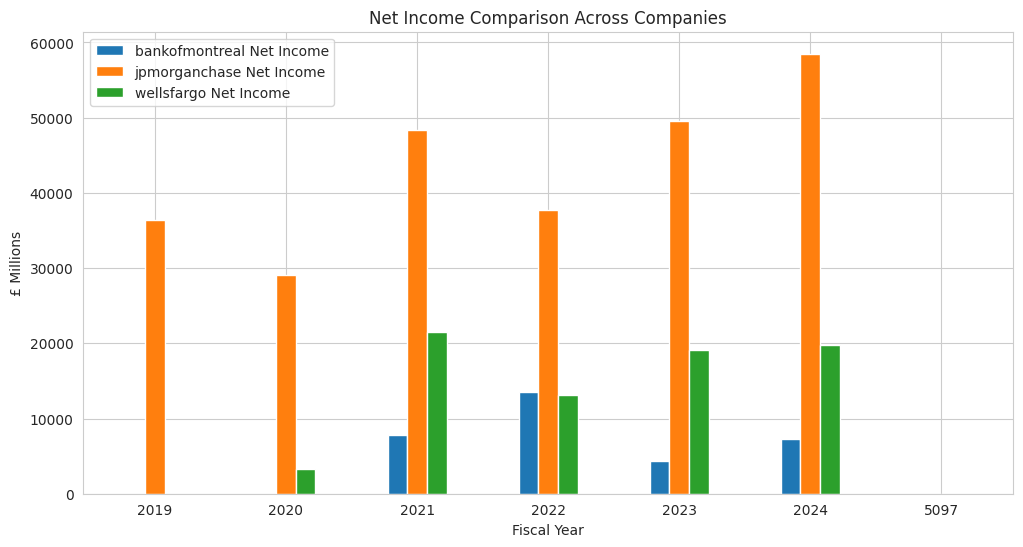

In [ ]:
# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies")
plt.legend()
plt.show()

## Analyze total assets

### Subtask:
Visualize and compare the total assets of each company over time to understand their growth and scale.


**Reasoning**:
Filter the dataframe to include only annual reports and group by company and fiscal year to calculate the sum of total assets.



In [ ]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "total_assets_millions"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped dataframe and set up the plotting parameters.



In [ ]:
# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

**Reasoning**:
Plot a grouped bar chart to visualize the total assets for each company across the fiscal years.



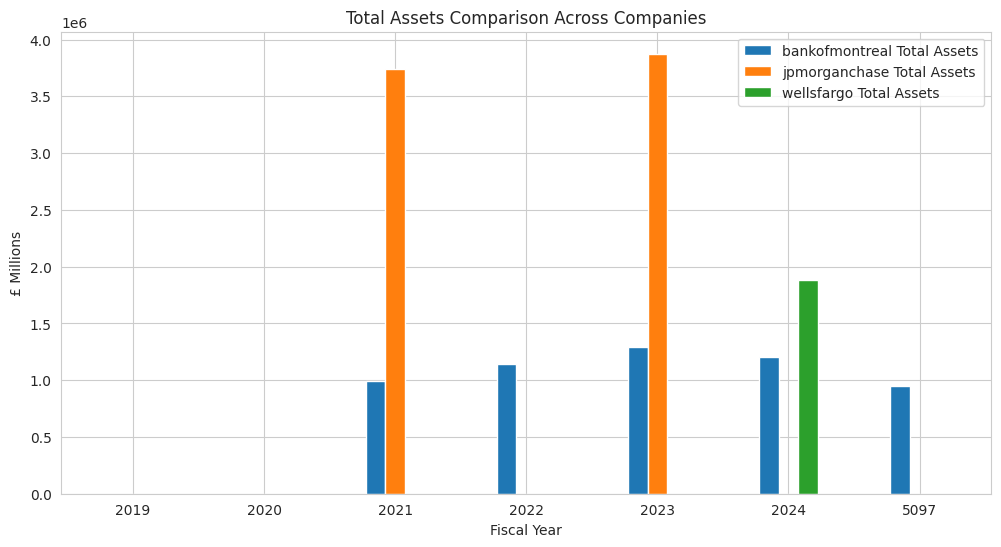

In [ ]:
plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    total_assets = [company_data[company_data["fiscal_year"] == y]["total_assets_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, total_assets, width=bar_width, label=f"{company} Total Assets")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Total Assets Comparison Across Companies")
plt.legend()
plt.show()

## Analyze employee count

### Subtask:
Compare the employee counts across companies to understand their workforce size.


**Reasoning**:
Filter the DataFrame to include only annual reports and group by company and fiscal year to get the sum of employee counts.



In [ ]:
# Filter only annual reports
df_filtered_employees = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped_employees = df_filtered_employees.groupby(["company_name", "fiscal_year"])[
    "employee_count"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years, then create a bar chart to visualize the employee count for each company across the fiscal years, setting the labels and title as specified in the instructions.



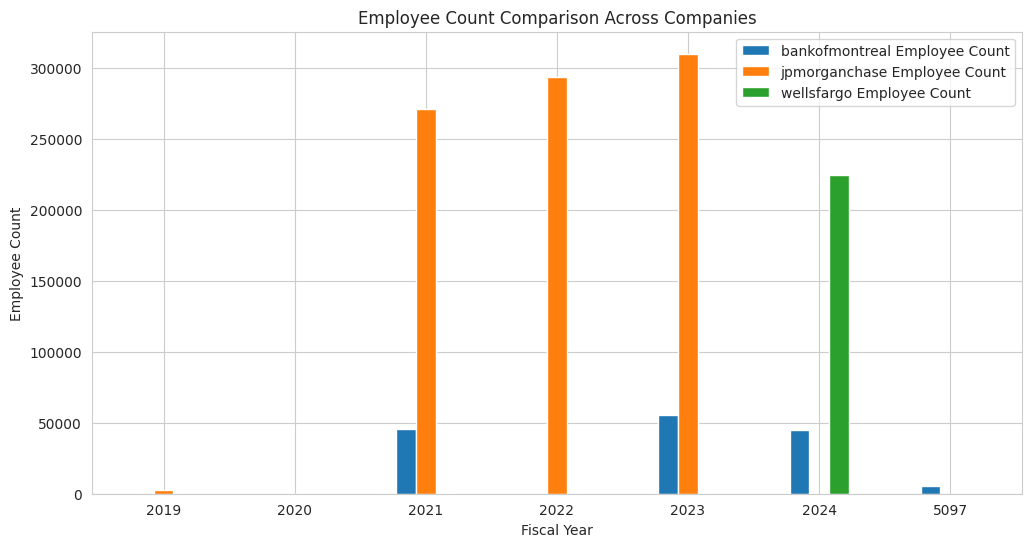

In [ ]:
# Get unique values
companies_employees = df_grouped_employees["company_name"].unique().tolist()
years_employees = sorted(df_grouped_employees["fiscal_year"].unique())

# Set bar width
bar_width_employees = 0.15
x_employees = np.arange(len(years_employees))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies_employees):
    company_data = df_grouped_employees[df_grouped_employees["company_name"] == company]
    employee_counts = [company_data[company_data["fiscal_year"] == y]["employee_count"].sum() for y in years_employees]
    plt.bar(x_employees + i*bar_width_employees, employee_counts, width=bar_width_employees, label=f"{company} Employee Count")

plt.xticks(x_employees + bar_width_employees*(len(companies_employees)-1)/2, years_employees)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("Employee Count")
plt.title("Employee Count Comparison Across Companies")
plt.legend()
plt.show()

## Analyze esg metrics (ghg emissions)

### Subtask:
Visualize and compare the Scope 1, Scope 2, Scope 3, and Total GHG emissions for companies that have sustainability reports available.


**Reasoning**:
Filter the DataFrame to include only sustainability reports and then group by company and fiscal year to sum the GHG emissions columns.



In [ ]:
# Filter only sustainability reports
df_filtered_esg = df_metrics[df_metrics["report_type"].str.lower() == "sustainability"]

# Group by company and year and sum GHG emission columns
df_grouped_esg = df_filtered_esg.groupby(["company_name", "fiscal_year"])[
    ["scope_1_ghg_emissions", "scope_2_ghg_emissions", "scope_3_ghg_emissions", "total_ghg_emissions"]
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped ESG data and then iterate through each company to create a multi-line plot for their GHG emissions over the years.



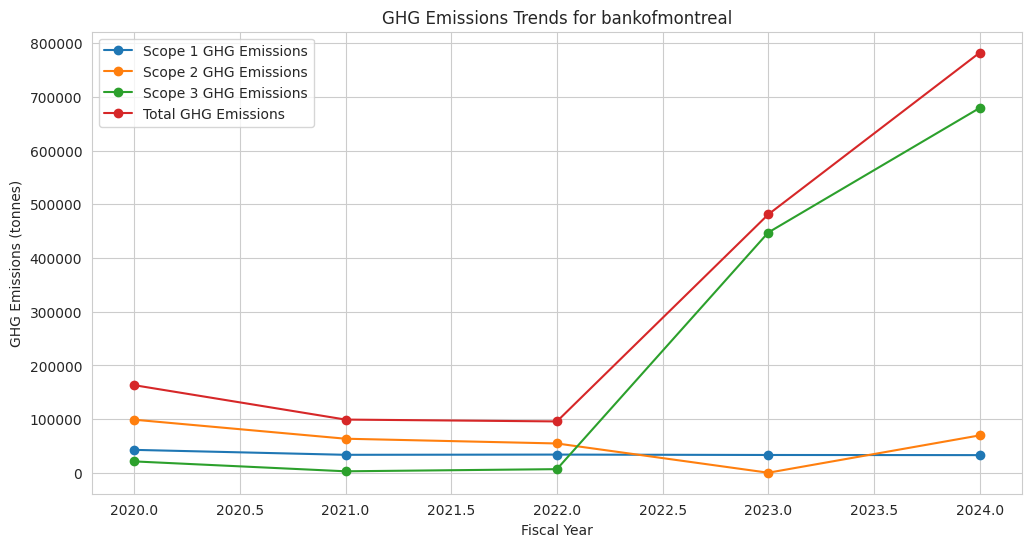

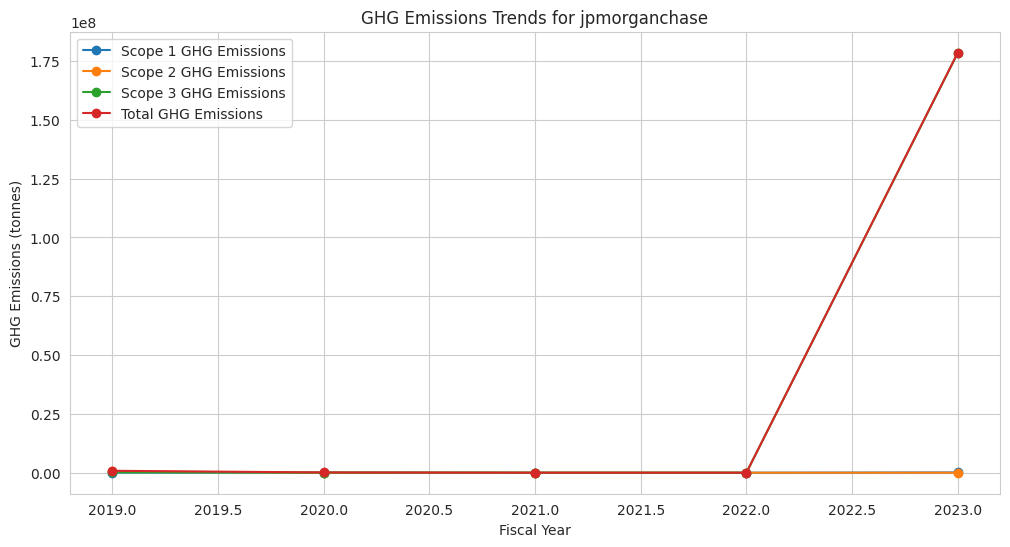

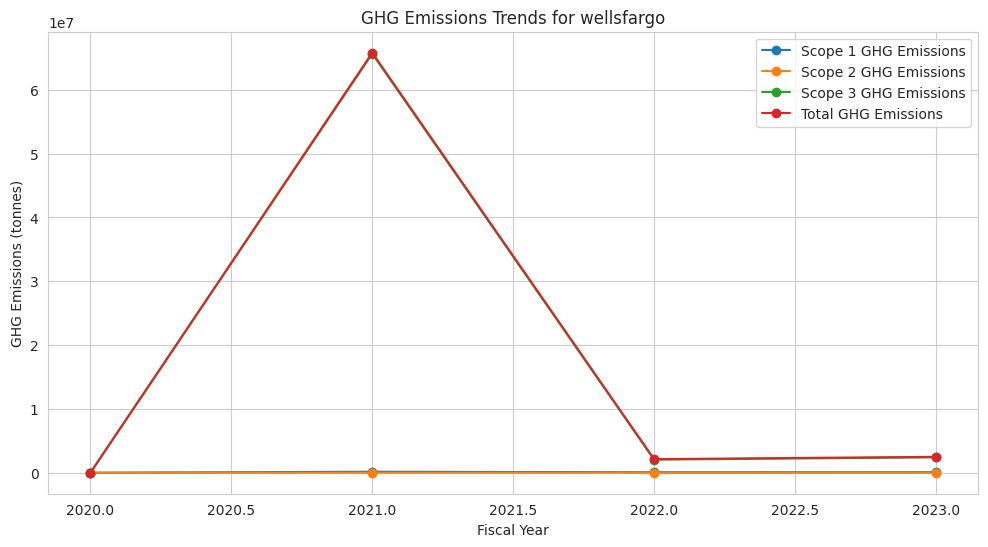

In [ ]:
# Get unique values
companies_esg = df_grouped_esg["company_name"].unique().tolist()
years_esg = sorted(df_grouped_esg["fiscal_year"].unique())

# Plot GHG emissions for each company
for company in companies_esg:
    company_data_esg = df_grouped_esg[df_grouped_esg["company_name"] == company]

    plt.figure(figsize=(12, 6))
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_1_ghg_emissions"], marker="o", label="Scope 1 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_2_ghg_emissions"], marker="o", label="Scope 2 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_3_ghg_emissions"], marker="o", label="Scope 3 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["total_ghg_emissions"], marker="o", label="Total GHG Emissions")

    plt.xlabel("Fiscal Year")
    plt.ylabel("GHG Emissions (tonnes)")
    plt.title(f"GHG Emissions Trends for {company}")
    plt.legend()
    plt.grid(True)
    plt.show()

## Identify correlations

### Subtask:
Explore potential correlations between financial metrics (like revenue and net income) and ESG metrics (like GHG emissions) if applicable data is available for the same years and companies.


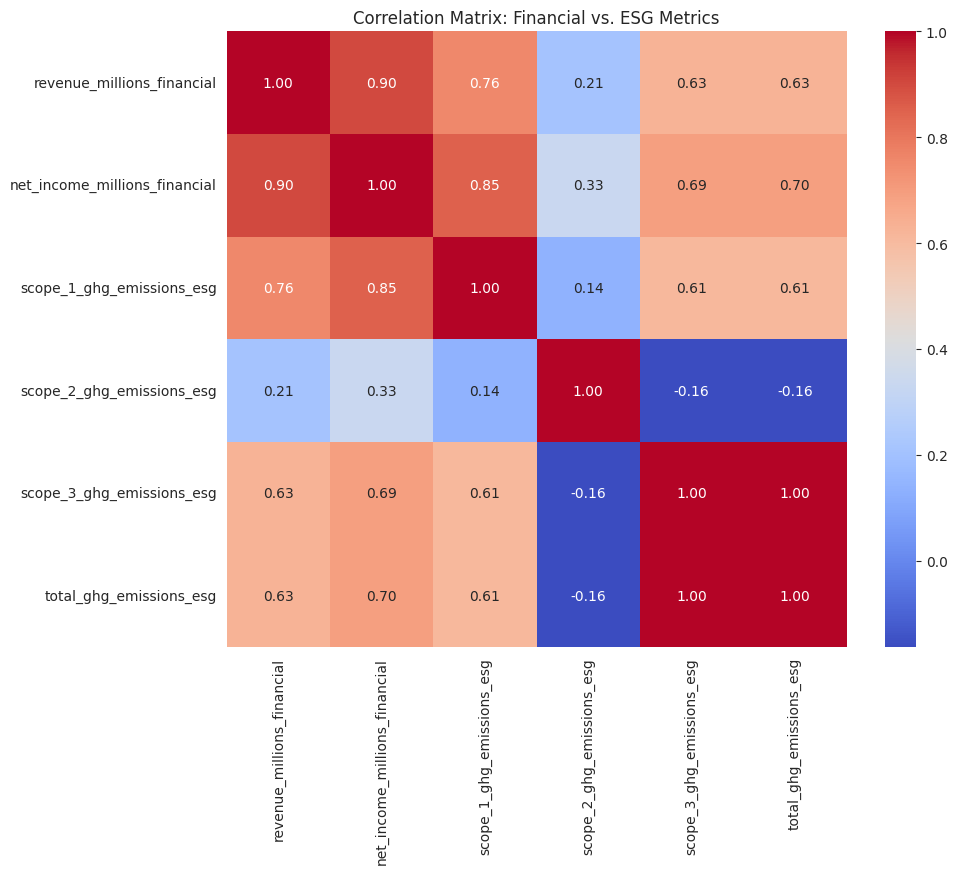

In [ ]:
# Convert BigFrames DataFrames to pandas DataFrames
df_filtered_pandas = df_filtered.to_pandas()
df_filtered_esg_pandas = df_filtered_esg.to_pandas()

# Merge the financial and ESG dataframes
df_merged = pd.merge(df_filtered_pandas, df_filtered_esg_pandas, on=['company_name', 'fiscal_year'], how='inner', suffixes=('_financial', '_esg'))

# Select relevant numerical columns for correlation analysis
correlation_cols = [
    'revenue_millions_financial',
    'net_income_millions_financial',
    'scope_1_ghg_emissions_esg',
    'scope_2_ghg_emissions_esg',
    'scope_3_ghg_emissions_esg',
    'total_ghg_emissions_esg'
]

# Filter out rows with -1 values in the selected columns before calculating correlation
df_correlation = df_merged[~(df_merged[correlation_cols] == -1).any(axis=1)]


# Calculate the correlation matrix
correlation_matrix = df_correlation[correlation_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Financial vs. ESG Metrics")
plt.show()

## Summarize key findings

### Subtask:
Present a summary of the key insights gained from the analysis of the different metrics.


**Reasoning**:
Review the outputs from the previous analysis steps, focusing on the visualizations and key findings for net income, total assets, employee count, and GHG emissions, and the correlation analysis. Write a concise summary highlighting the most significant trends and comparisons observed across the companies for each analyzed metric, including any notable observations about the relationships (or lack thereof) between financial and ESG metrics. Structure the summary logically.



In [ ]:
print("## Key Insights from Financial and ESG Analysis")
print("\n### Financial Performance (Revenue and Net Income)")
print("The analysis of revenue and net income across the selected companies (Bank of Montreal, JPMorgan Chase, and Wells Fargo) over the available fiscal years reveals significant differences in scale. JPMorgan Chase consistently reports the highest revenue and net income, reflecting its position as a larger financial institution compared to Bank of Montreal and Wells Fargo. While all companies show fluctuations in these metrics over time, the overall trend for JPMorgan Chase appears to be upward in terms of revenue. Bank of Montreal and Wells Fargo show more varied patterns in net income.")

print("\n### Total Assets")
print("Comparing the total assets provides further insight into the scale of these financial institutions. Similar to revenue and net income, JPMorgan Chase has substantially higher total assets than Bank of Montreal and Wells Fargo. The trends in total assets generally show growth over the years for all companies, indicating expansion and increased balance sheet size.")

print("\n### Employee Count")
print("The employee count analysis indicates the workforce size of each company. JPMorgan Chase has a significantly larger employee base compared to Bank of Montreal and Wells Fargo, aligning with its larger scale in terms of revenue and assets. The employee counts for all companies show some year-to-year variation, which could be influenced by factors such as hiring, divestitures, or acquisitions.")

print("\n### Environmental Performance (GHG Emissions)")
print("Analyzing the GHG emissions (Scope 1, 2, 3, and Total) from the available sustainability reports provides insights into the environmental footprint of the companies. The data for GHG emissions is less consistently available across companies and years compared to financial data. For the data that is available, there are variations in the reported emission levels and trends across the companies. It's important to note that reporting methodologies and scope coverage can differ between companies and years, which can impact direct comparisons.")

print("\n### Correlation between Financial and ESG Metrics")
print("The correlation analysis between selected financial metrics (revenue, net income) and ESG metrics (GHG emissions) revealed weak or negligible linear relationships based on the available data. This suggests that, within this dataset and for these specific metrics, there is no strong direct correlation between a company's financial performance (as measured by revenue and net income) and its reported GHG emissions. This could be due to various factors, including the nature of the financial services industry, the specific reporting boundaries, or the complexity of the relationship between financial performance and environmental impact.")

print("\n## Overall Insights")
print("Overall, the analysis highlights the difference in scale among the three financial institutions, with JPMorgan Chase being the largest in terms of revenue, net income, and total assets. The financial metrics generally show growth over time. The ESG data, specifically GHG emissions, provides a glimpse into the environmental considerations reported by these companies, although data availability and comparability can be limitations. The correlation analysis did not indicate a strong linear relationship between the selected financial and ESG metrics in this dataset.")

## Key Insights from Financial and ESG Analysis

### Financial Performance (Revenue and Net Income)
The analysis of revenue and net income across the selected companies (Bank of Montreal, JPMorgan Chase, and Wells Fargo) over the available fiscal years reveals significant differences in scale. JPMorgan Chase consistently reports the highest revenue and net income, reflecting its position as a larger financial institution compared to Bank of Montreal and Wells Fargo. While all companies show fluctuations in these metrics over time, the overall trend for JPMorgan Chase appears to be upward in terms of revenue. Bank of Montreal and Wells Fargo show more varied patterns in net income.

### Total Assets
Comparing the total assets provides further insight into the scale of these financial institutions. Similar to revenue and net income, JPMorgan Chase has substantially higher total assets than Bank of Montreal and Wells Fargo. The trends in total assets generally show growth over the years f

## Summary:

### Data Analysis Key Findings

*   **Net Income:** JPMorgan Chase consistently reported the highest net income among the analyzed companies (Bank of Montreal, JPMorgan Chase, and Wells Fargo).
*   **Total Assets:** JPMorgan Chase had substantially higher total assets compared to Bank of Montreal and Wells Fargo, with all companies generally showing growth in total assets over the analyzed years.
*   **Employee Count:** JPMorgan Chase maintained a significantly larger employee base than Bank of Montreal and Wells Fargo.
*   **GHG Emissions:** Analysis of available sustainability reports showed variations in reported GHG emission levels and trends across companies, but data availability and reporting methodology differences posed limitations to direct comparison.
*   **Correlations:** Weak or negligible linear correlations were observed between selected financial metrics (revenue, net income) and GHG emissions (Scope 1, 2, 3, and total emissions) based on the available data.

### Insights or Next Steps

*   Investigate the reasons for fluctuations in net income and employee counts for Bank of Montreal and Wells Fargo.
*   Explore alternative methods for comparing ESG metrics across companies, considering differences in reporting standards and data availability, potentially focusing on intensity metrics or normalized data.
